# Dataset: Yahoo Finance
https://finance.yahoo.com/quote/BTC-USD/history?p=BTC-USD

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

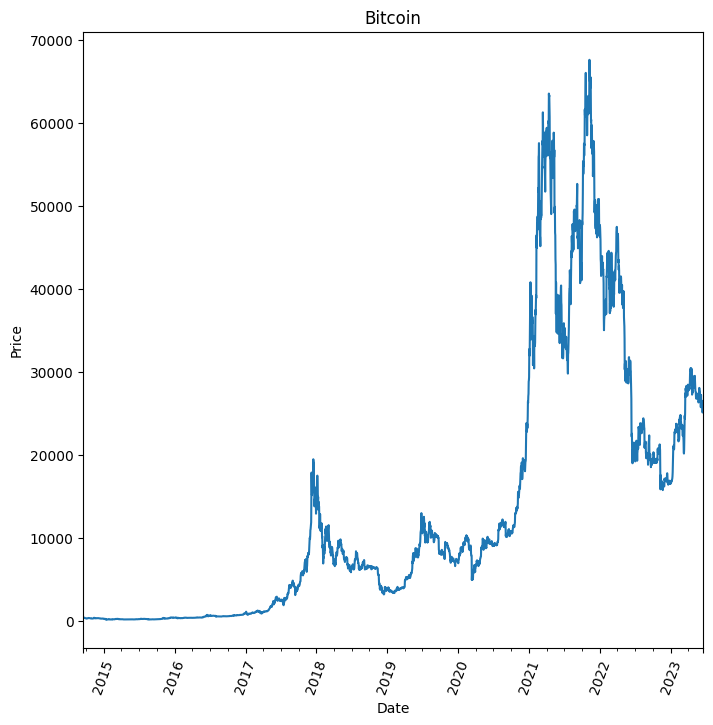

In [50]:
#import dataset
data = pd.read_csv('BTC-USD.csv')

# #drop missing data
data = data.dropna()

#Turn UTC time format into date type
data['Date'] = pd.to_datetime(data['Date'])

#Turn data into index
data.set_index('Date', drop = True, inplace =True)

#Plot the graph
plt.figure(figsize = (8,8))
data.Close.plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin')
plt.xticks(rotation = 70)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

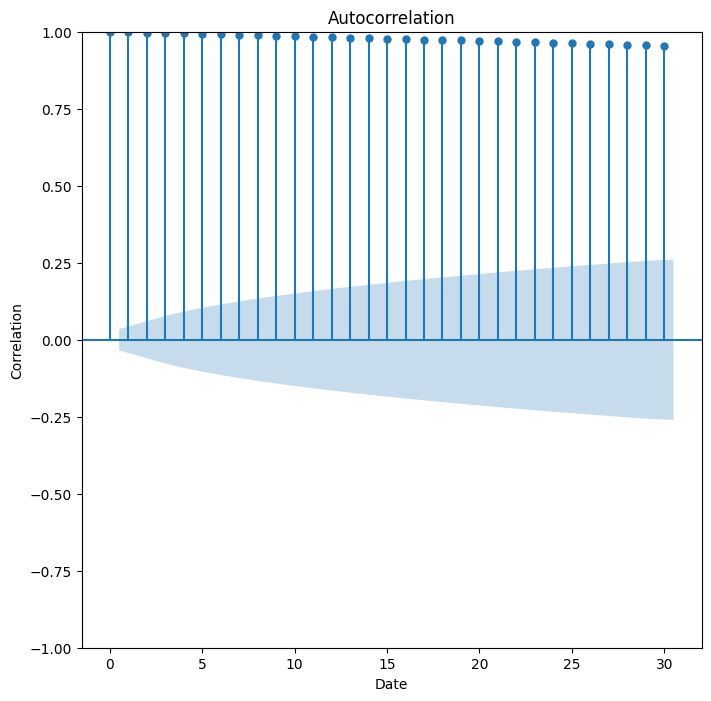

In [51]:
#Calculate the autocorrelation, 
fig, axes = plt.subplots(figsize = (8,8))
plot_acf(data.Close, axes, lags = 30)
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.show

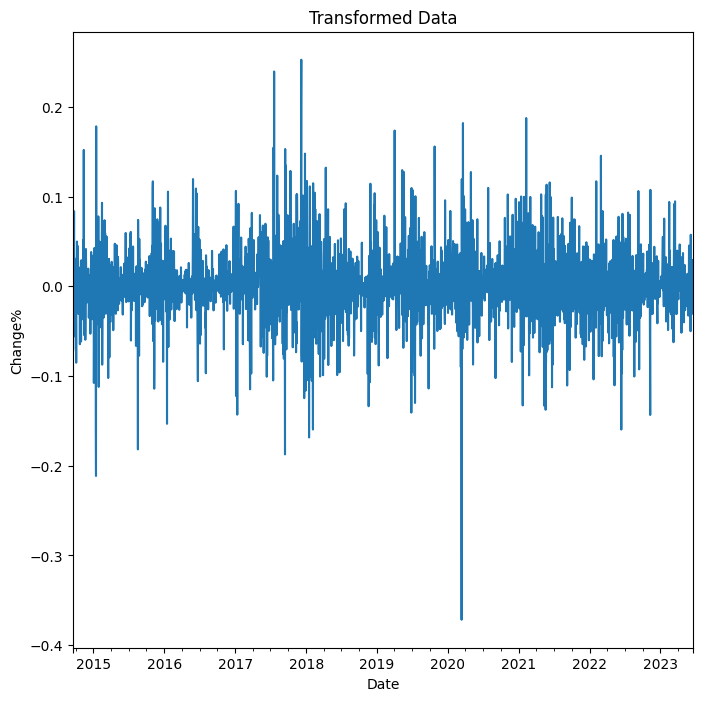

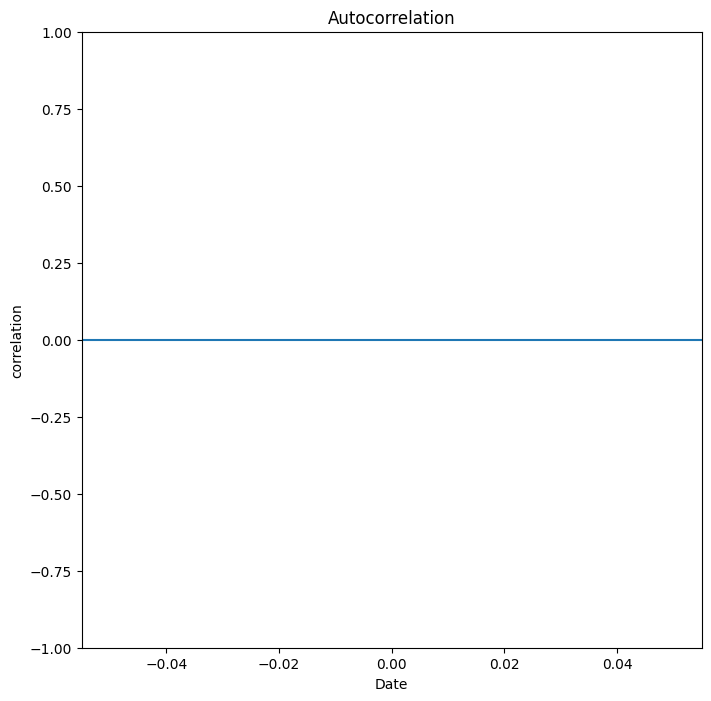

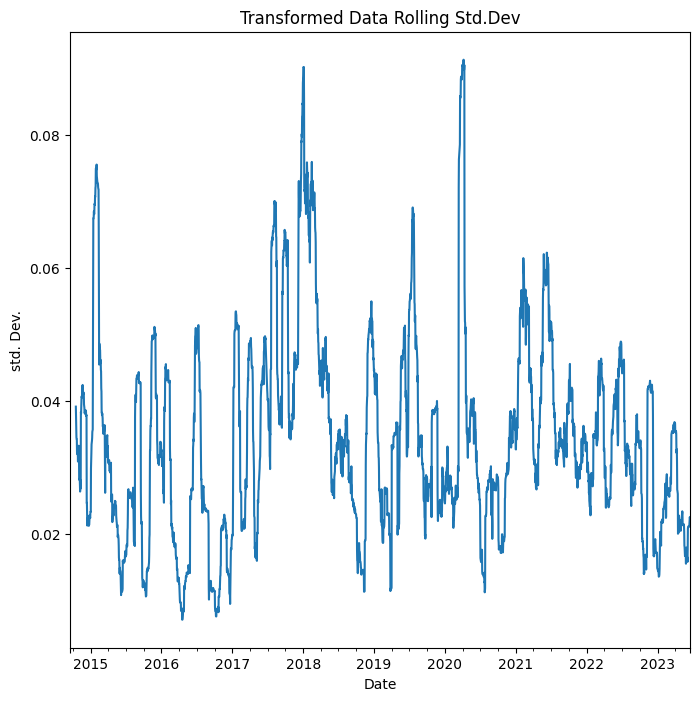

In [83]:
#Turn changes into percentage
data['diffs'] = (data.Close.diff() / data.Close.shift(periods = 1, fill_value = 0)).values
data['diffs'].fillna(0)

# #Plot graph
plt.figure(figsize = (8, 8))
data.diffs.plot()
plt.xlabel('Date')
plt.ylabel('Change%')
plt.title('Transformed Data')
plt.show()


#acf
fig, axes = plt.subplots(figsize = (8,8))
plot_acf(data.diffs, axes, lags=60)
plt.xlabel('Date')
plt.ylabel('correlation')
plt.show()


plt.figure(figsize = (8,8))
data.diffs.rolling(30).std().plot()
plt.xlabel('Date')
plt.ylabel('std. Dev.')
plt.title('Transformed Data Rolling Std.Dev')
plt.show()